In [1]:
import pandas as pd
from pandas_datareader import data
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm

In [2]:
plt.style.use("fivethirtyeight")

## Download price data

In [3]:
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2022,6,30)

In [4]:
df = data.DataReader("INFY.NS","yahoo", start, end)[["Adj Close"]].round(2)

In [5]:
df = df.rename(columns ={'Adj Close':"price"})
df

,price
Date,
2014-01-01,350.56
2014-01-02,351.83
2014-01-03,360.38
2014-01-06,355.61
2014-01-07,349.47
...,...
2022-06-24,1441.10
2022-06-27,1474.60
2022-06-28,1480.15


## Calculating Returns

### Simple Returns

  ### $Returns = \frac {P_{t} - P_{t-1}}{P_{t-1}}$
  

### Log Returns 


### $Log Returns = log \frac {P_{t}}{P_{t-1}} = log (P_{t}) -log (P_{t-1}) $




- __$P_{t}$ is price at time $t$,__  
- __$P_{t-1}$ is price at time ${t-1}$__

In [6]:
df["simple_rets"] = df["price"].pct_change()
df["log_rets"] = np.log(df["price"]/df["price"].shift(1))

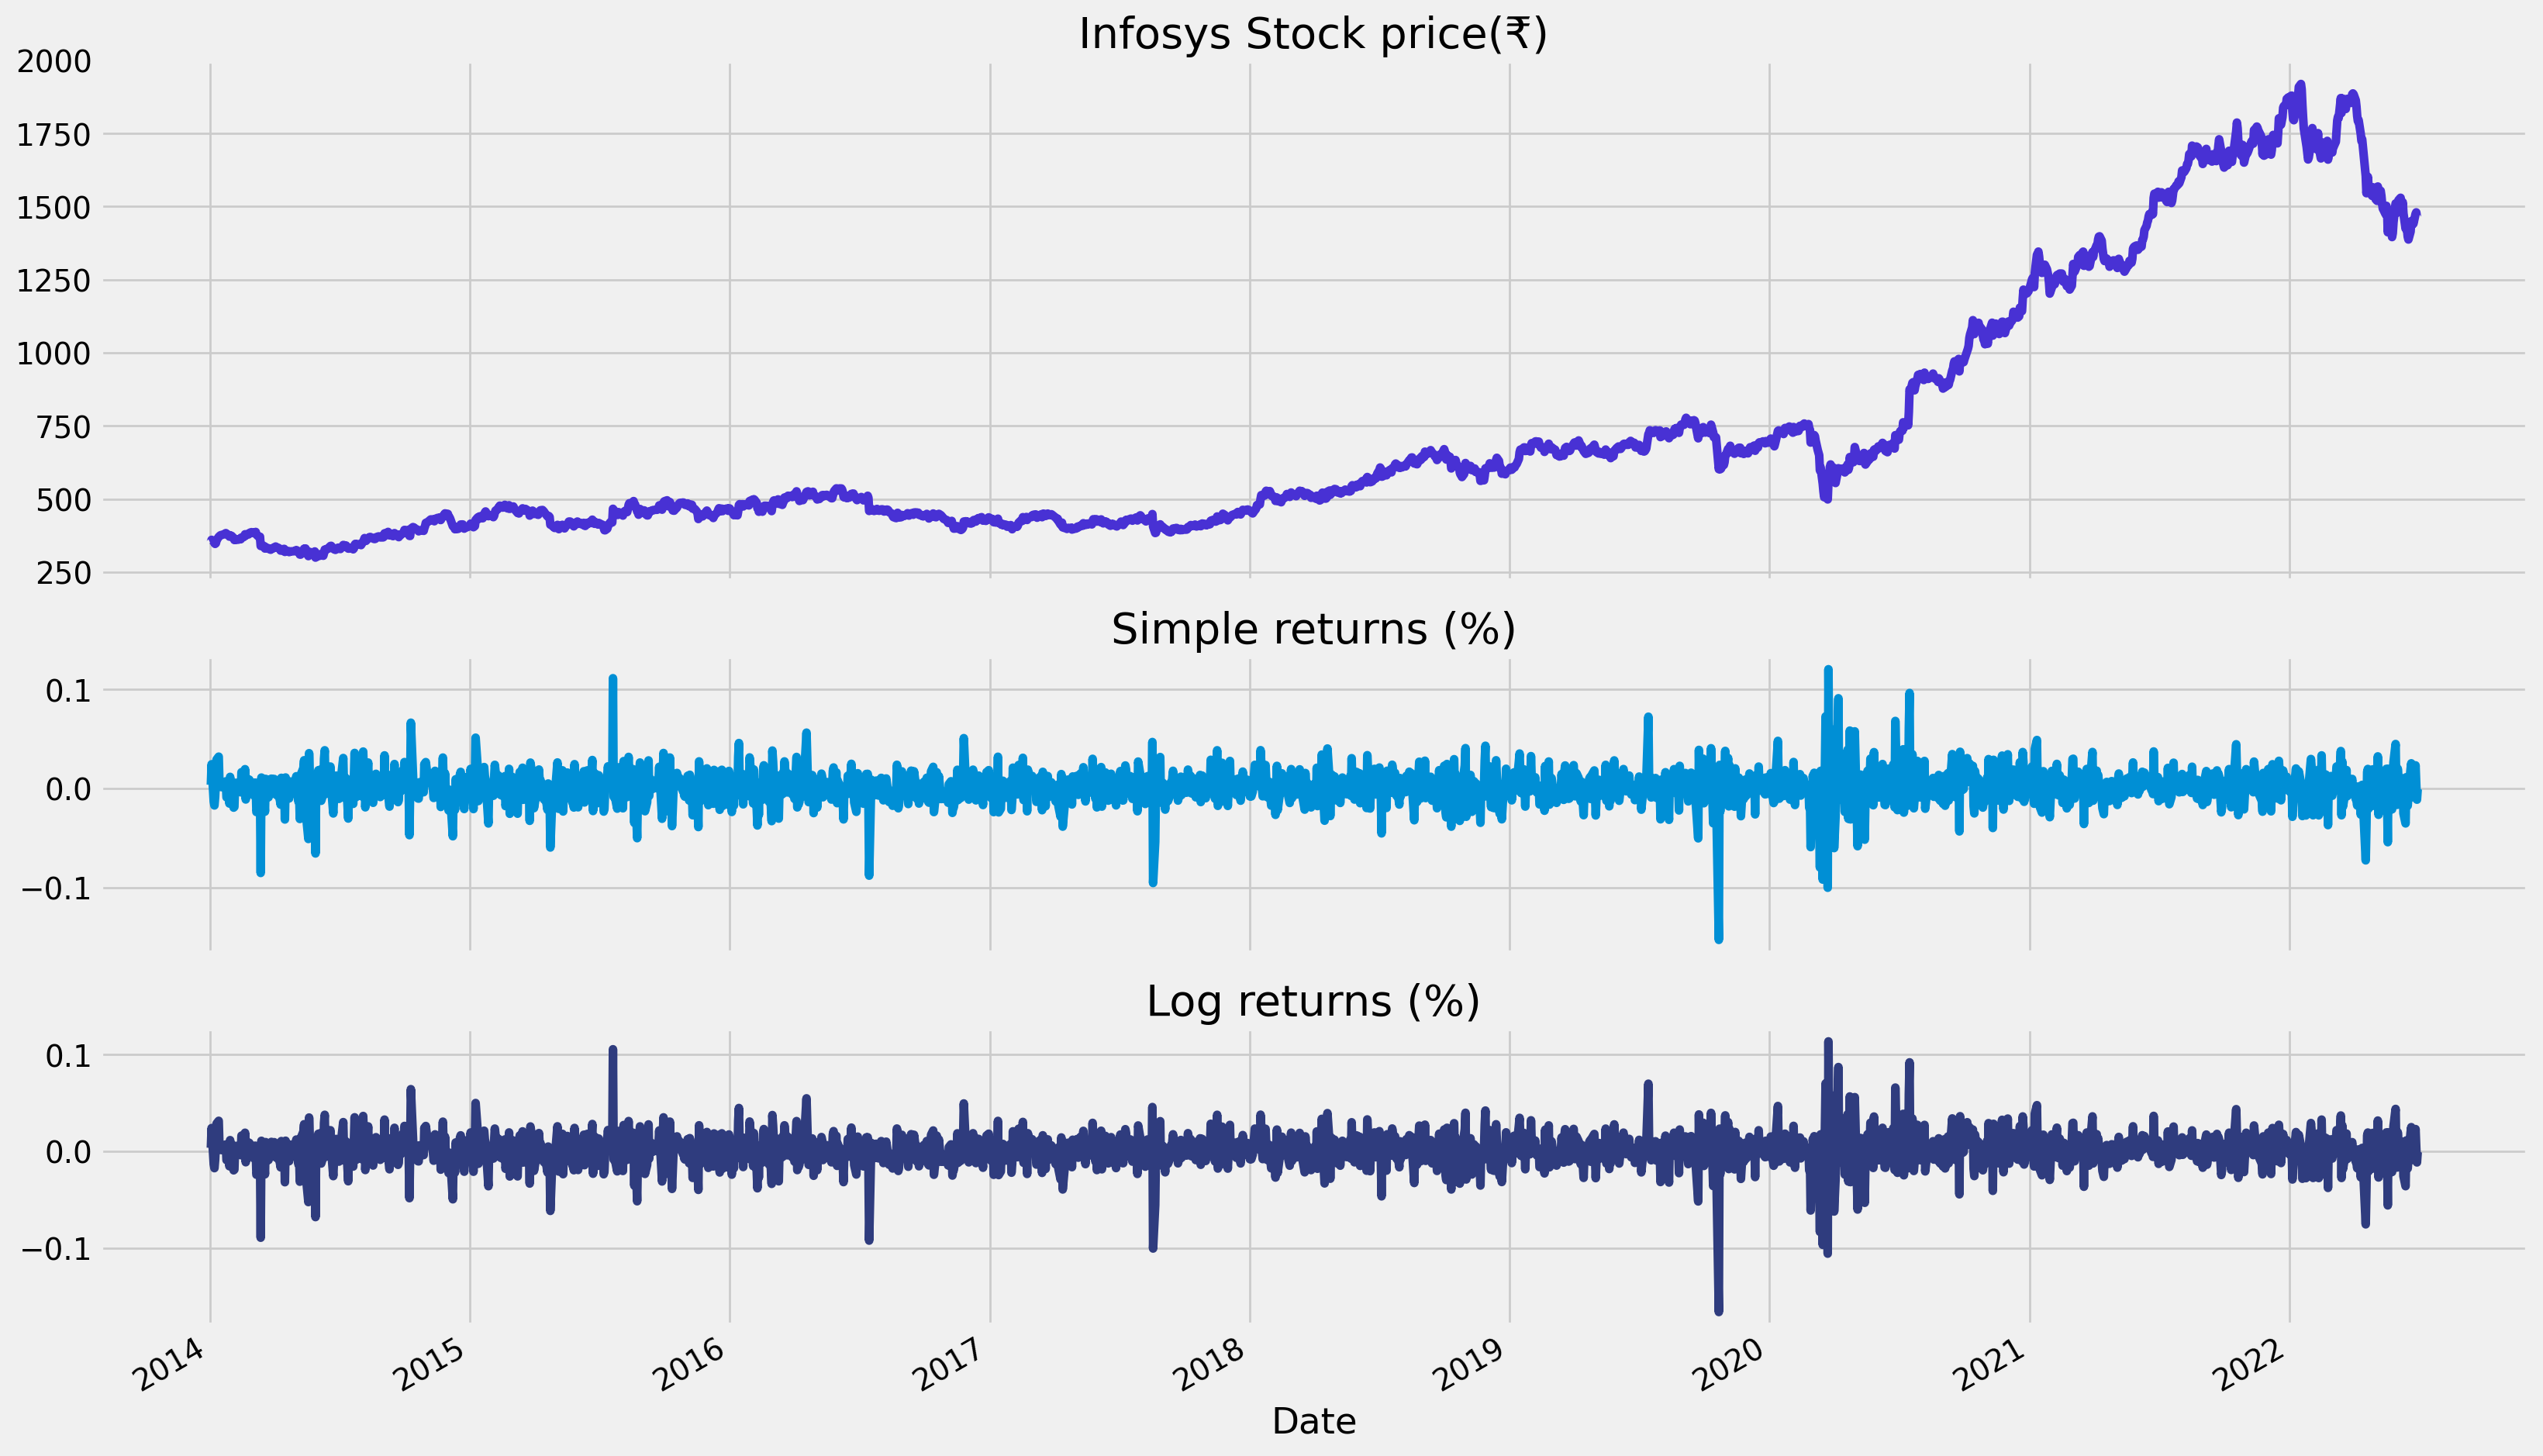

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(18, 12),dpi = 200, sharex=True,gridspec_kw={'height_ratios': [1.75, 1, 1]})
df["price"].plot(ax=ax[0], color = "#4831D4")
ax[0].set(title = 'Infosys Stock price(\u20B9)')
df["simple_rets"].plot(ax=ax[1])
ax[1].set(title = 'Simple returns (%)')
df["log_rets"].plot(ax=ax[2], color ="#2F3C7E")
ax[2].set(title = 'Log returns (%)');

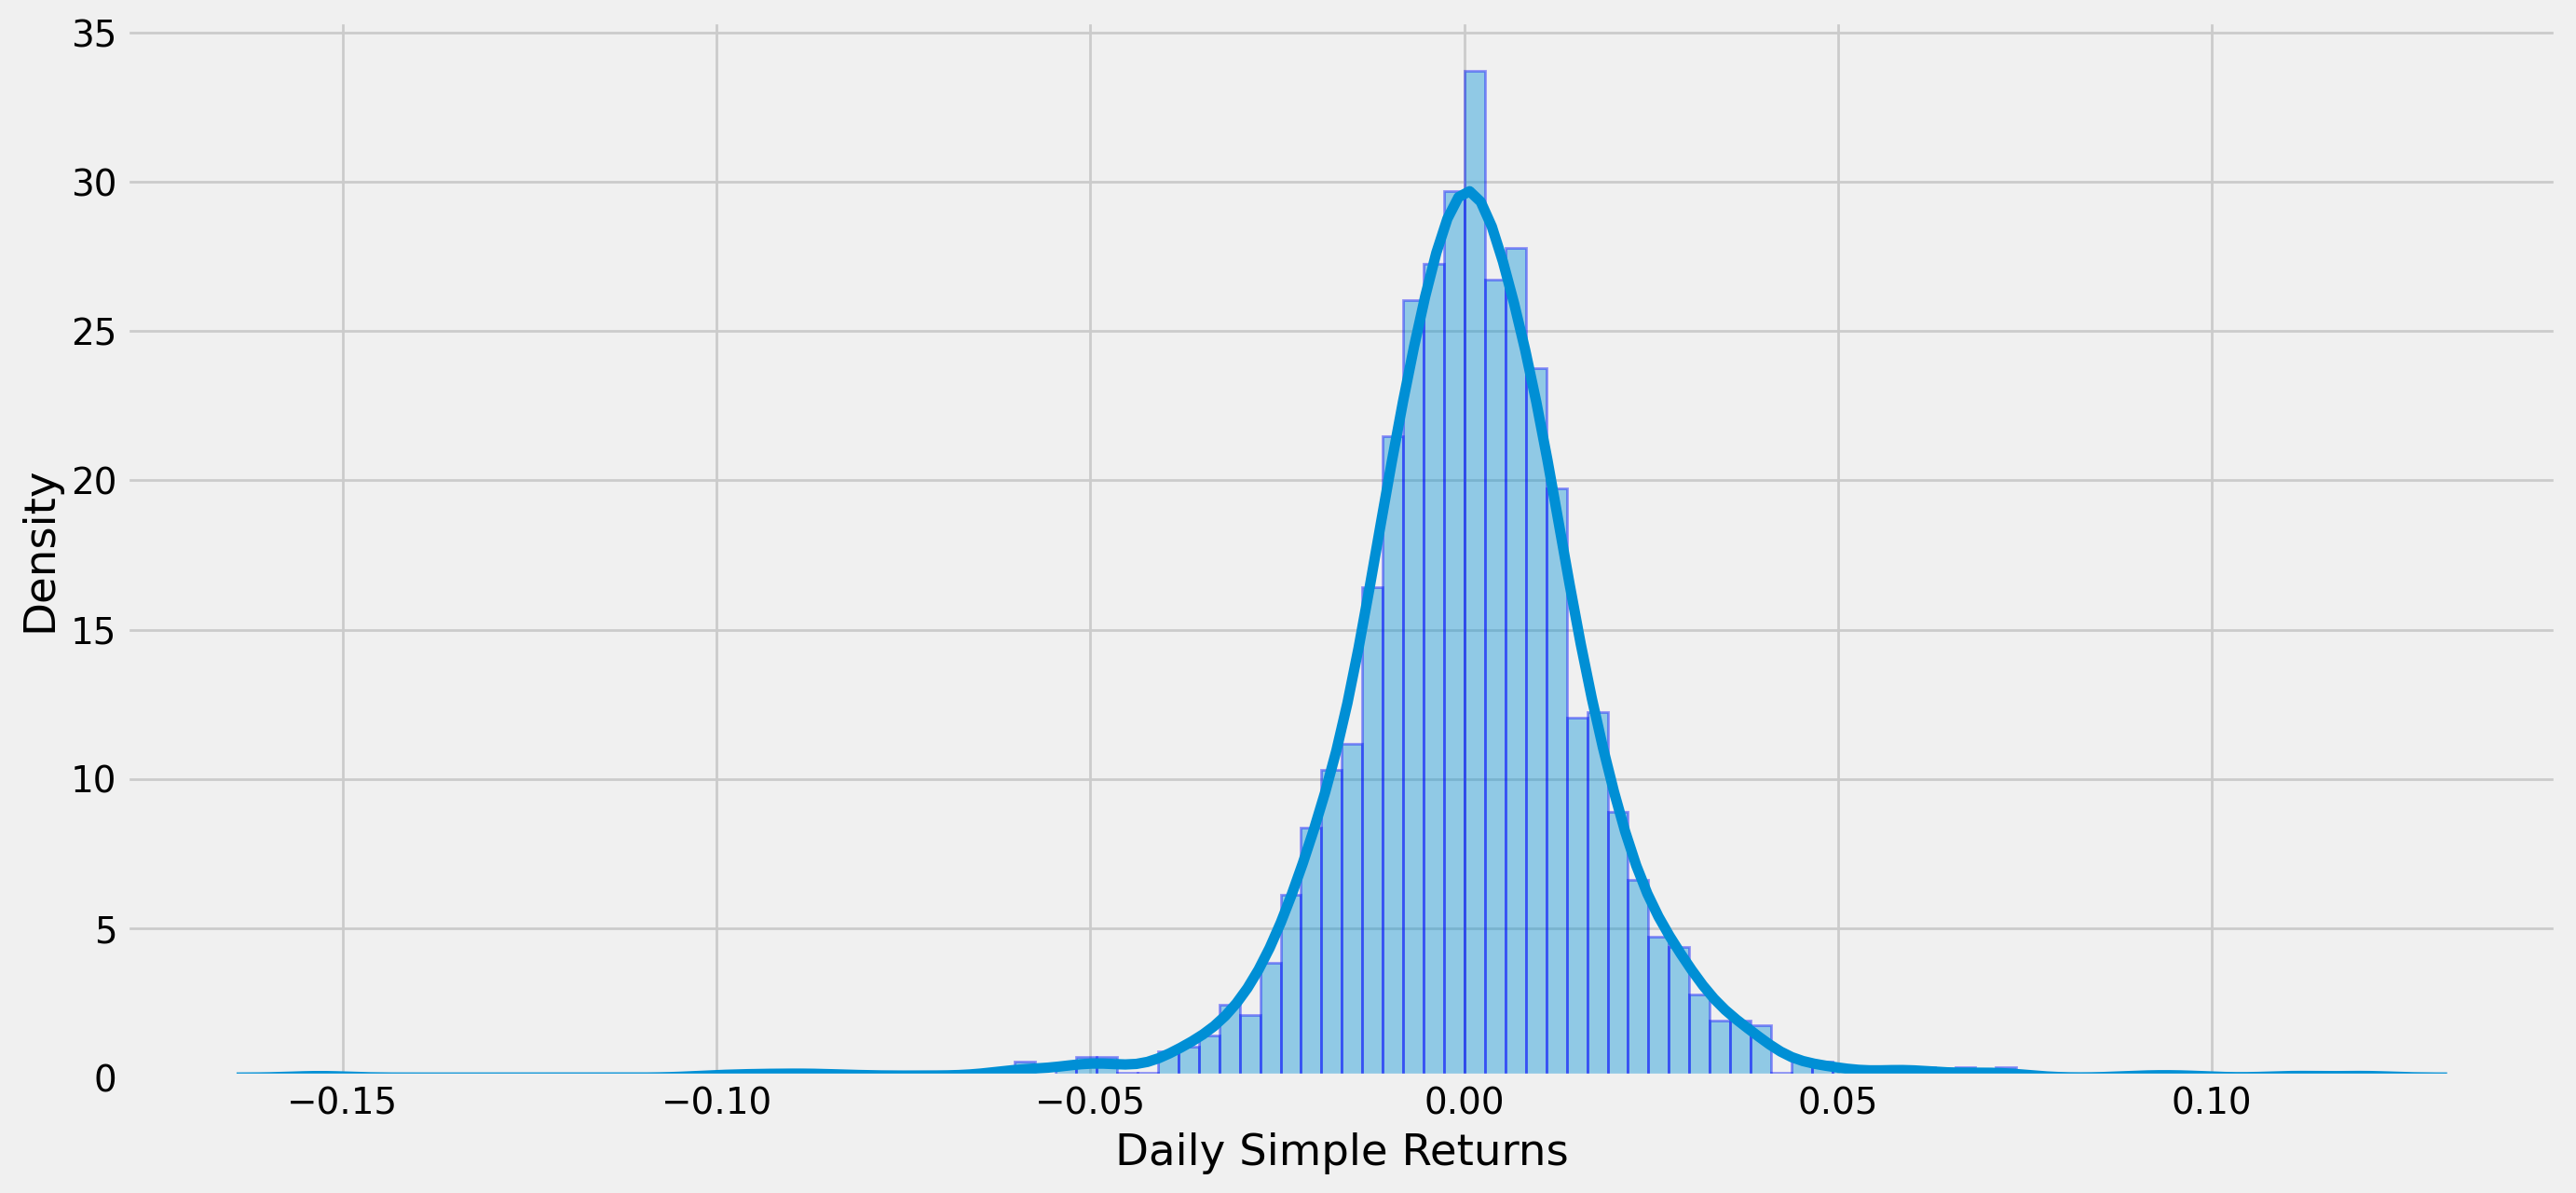

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(15, 7),dpi=200)
snplot =sns.distplot(df["simple_rets"], bins =100,hist_kws=dict(edgecolor="b", linewidth=1))
plt.xlabel("Daily Simple Returns");

## Realized Volatility

### RV = $\sqrt{\Sigma r_{t}^2}$

__$r_{t}$ refers to returns at time (t)__

In [9]:
def realized_volatitility(x):
    return np.sqrt (np.sum(x**2))

In [10]:
df["real_vol"] =df["log_rets"].resample("M").apply(realized_volatitility)*np.sqrt(12)
df["real_vol"].dropna().tail(3)

Date
2022-03-31    0.244772
2022-05-31    0.355773
2022-06-30    0.260621
Name: real_vol, dtype: float64

### Identify extreme returns over 21 day rolling window

In [11]:
df["rolling_mean_21"] = df["simple_rets"].rolling(21).mean()
df["rolling_sd_21"] = df["simple_rets"].rolling(21).std()
df_outlier = df[["simple_rets","rolling_mean_21","rolling_sd_21"]].dropna()
df_outlier.head()

,simple_rets,rolling_mean_21,rolling_sd_21
Date,,,
2014-01-30,-0.003619,0.003228,0.013306
2014-01-31,-0.000855,0.003015,0.013335
2014-02-03,-0.019458,0.000931,0.013261
2014-02-04,-0.018754,0.000668,0.013606
2014-02-05,0.005667,0.001760,0.013002


In [12]:
def outlier_check(row, std_level =3):
    rets = row["simple_rets"]
    mean   = row["rolling_mean_21"]
    sd  = row["rolling_sd_21"] 
    
    if (rets> mean + 3*sd)| (rets < mean - 3*sd):
        return 1
    else :
        return 0

In [13]:
df_outlier["check_outlier"] = df_outlier.apply(outlier_check, axis =1)
#filter outliers only

outliers= df_outlier[df_outlier["check_outlier"]==1][["simple_rets"]]
outliers

,simple_rets
Date,
2014-03-13,-0.085446
2015-07-21,0.111254
2016-07-15,-0.088172
2016-11-25,0.050728
2017-08-18,-0.095610
2019-07-15,0.072380
2019-09-23,-0.050488
2019-10-22,-0.153064
2020-01-13,0.047959


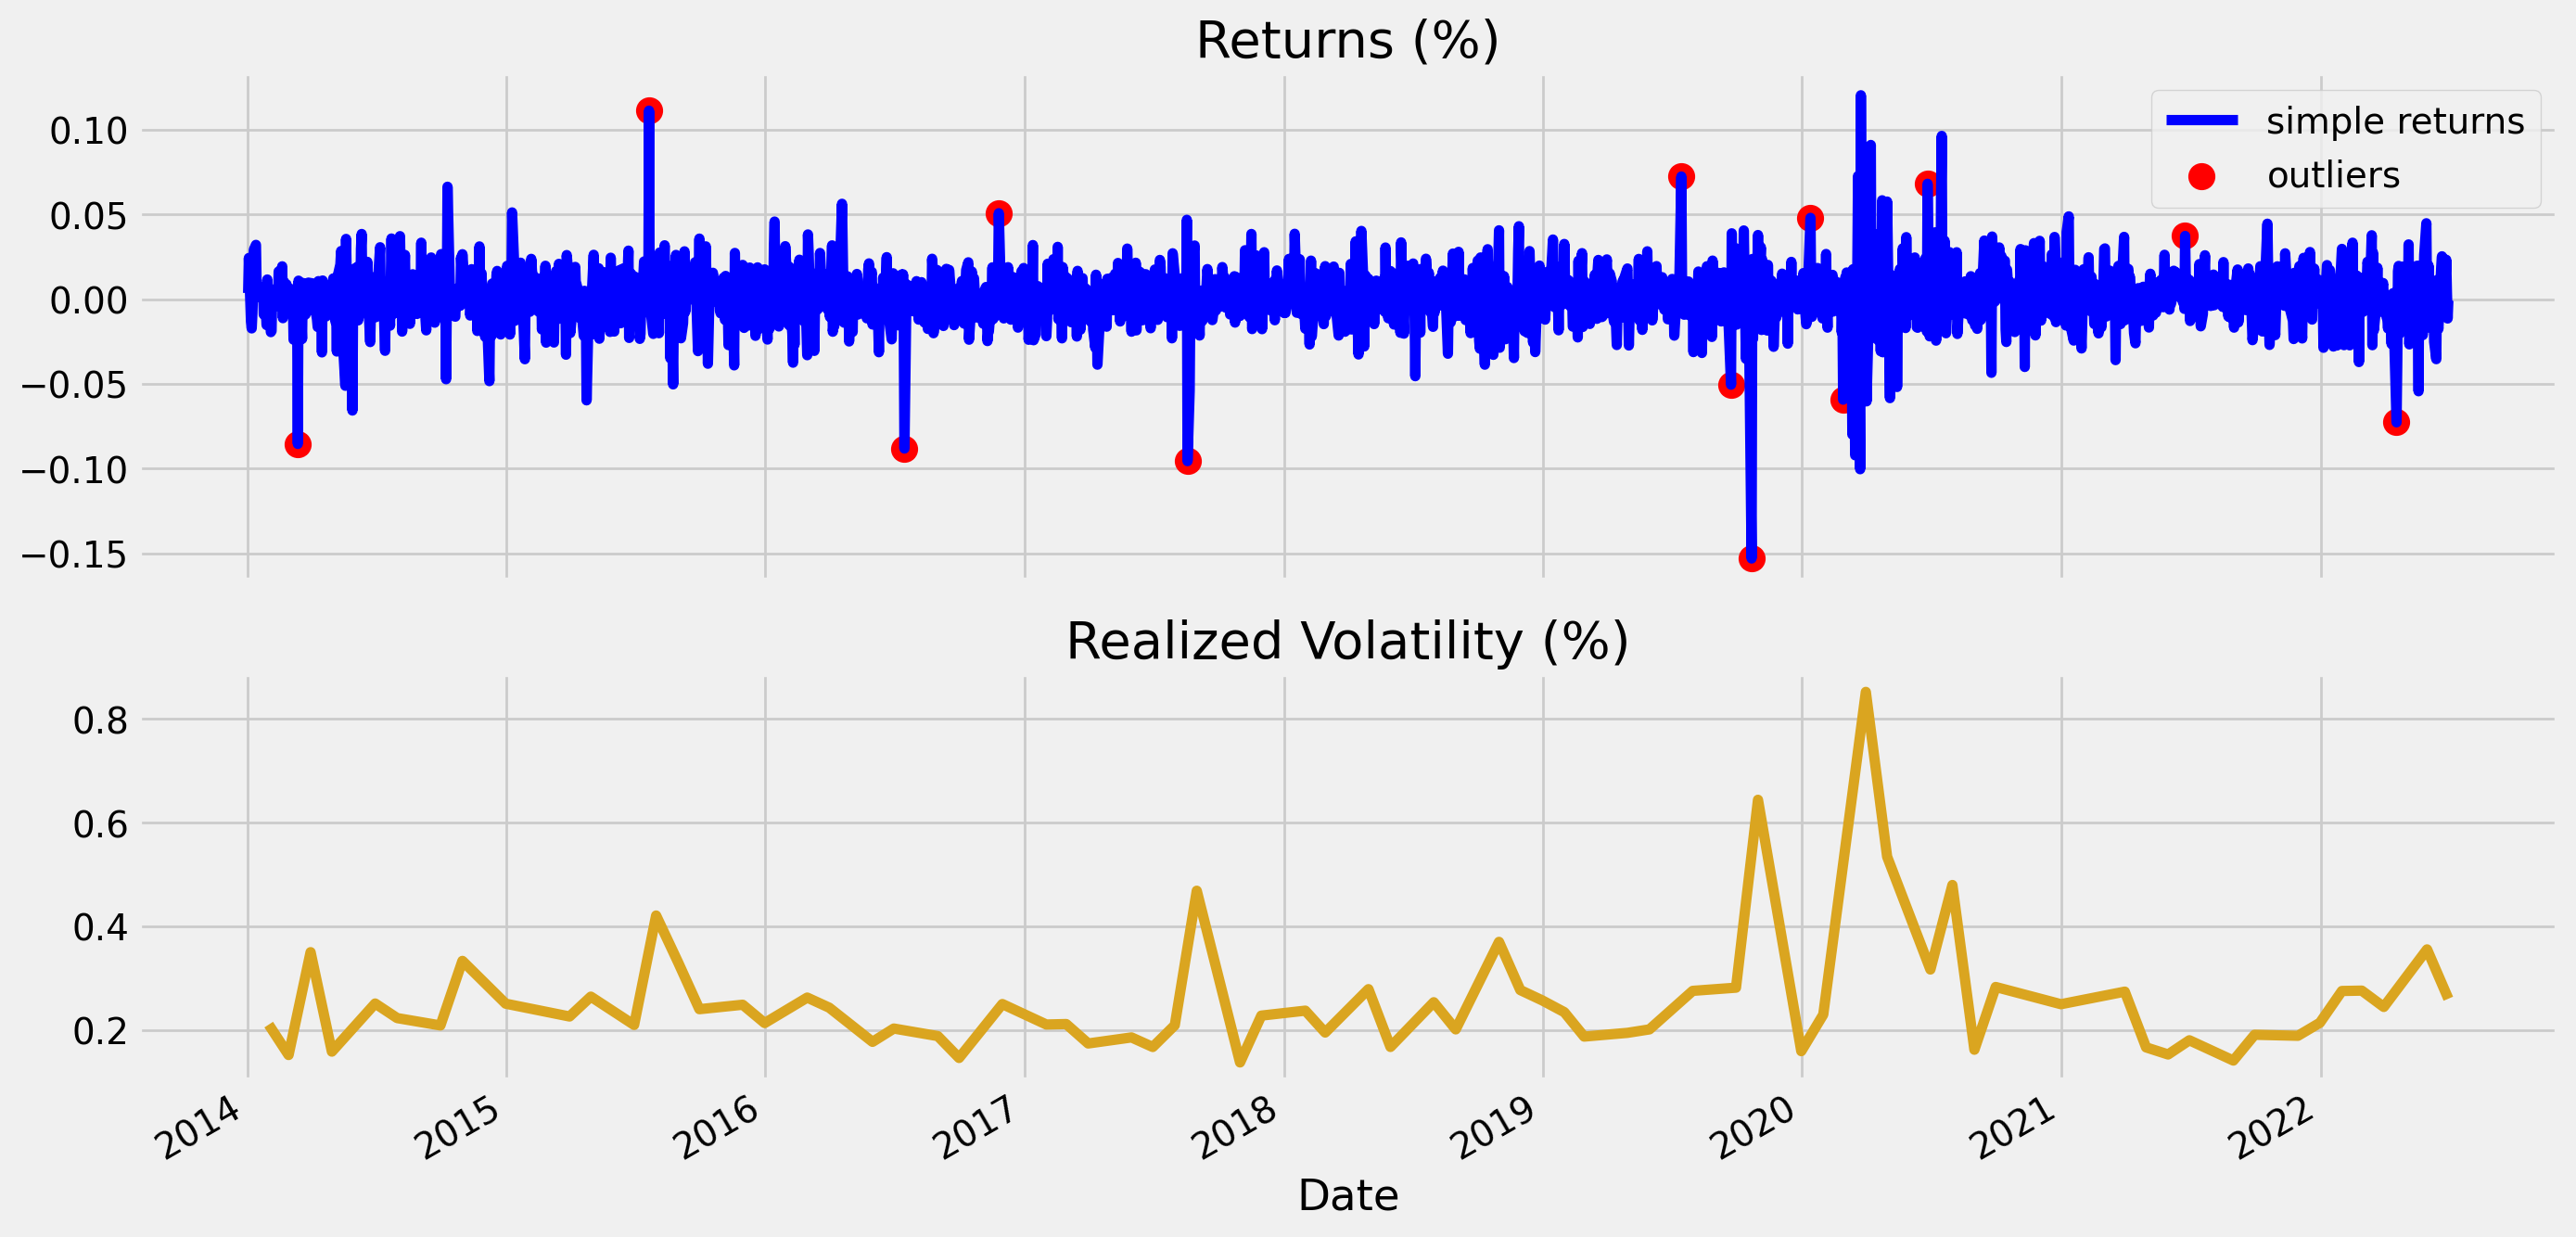

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True, dpi = 200,gridspec_kw={'height_ratios': [1.25, 1]})

ax[0].plot(df.index, df["simple_rets"],color ="b", label ="simple returns")
ax[0].scatter(outliers.index, outliers["simple_rets"], color='r',s=100, label ="outliers")
ax[0].set(title = 'Returns (%)')
ax[0].legend(loc ="upper right")
df["real_vol"].dropna().plot(ax=ax[1], color ="#DAA520")
ax[1].set(title = 'Realized Volatility (%)');

## Scaling Returns & Volatility 

### Annualized Return 
#### Annualized Return$ = (1+R)^{1/N} -1$

- __R__ is the calculated return
- __N__ is the No. of years 

### Annualized Volatility 
#### Annualized Volatility $= \sigma . \sqrt p $

- __$\sigma$__ is the standard deviation
- __p__ is the No. of trading periods (252 for daily, 12 for monthly, 4 for quarterly data)

In [15]:
returns = df["simple_rets"].dropna()
n_periods =returns.shape[0]

# Calculating on daily returns, assuming 252 trading days  in a year
annualized_return =(returns +1).prod()**(252/n_periods) -1
annualized_return*100

18.749522130802365

In [16]:
annualized_vol = returns.std()* np.sqrt(252)
annualized_vol*100

27.203198175124182

In [17]:
print("Infosys (INFY) \n**************")
print("for period 1/1/2014 to 30/6/2022\n")

print(f"Annualized Return     : {(annualized_return*100).round(2)} %")
print(f"Annualized Volatility : {(annualized_vol*100).round(2)} %")

Infosys (INFY) 
**************
for period 1/1/2014 to 30/6/2022

Annualized Return     : 18.75 %
Annualized Volatility : 27.2 %


# Moments of Distribution

## 1st & 2nd Moments ( Mean & Std Deviation)

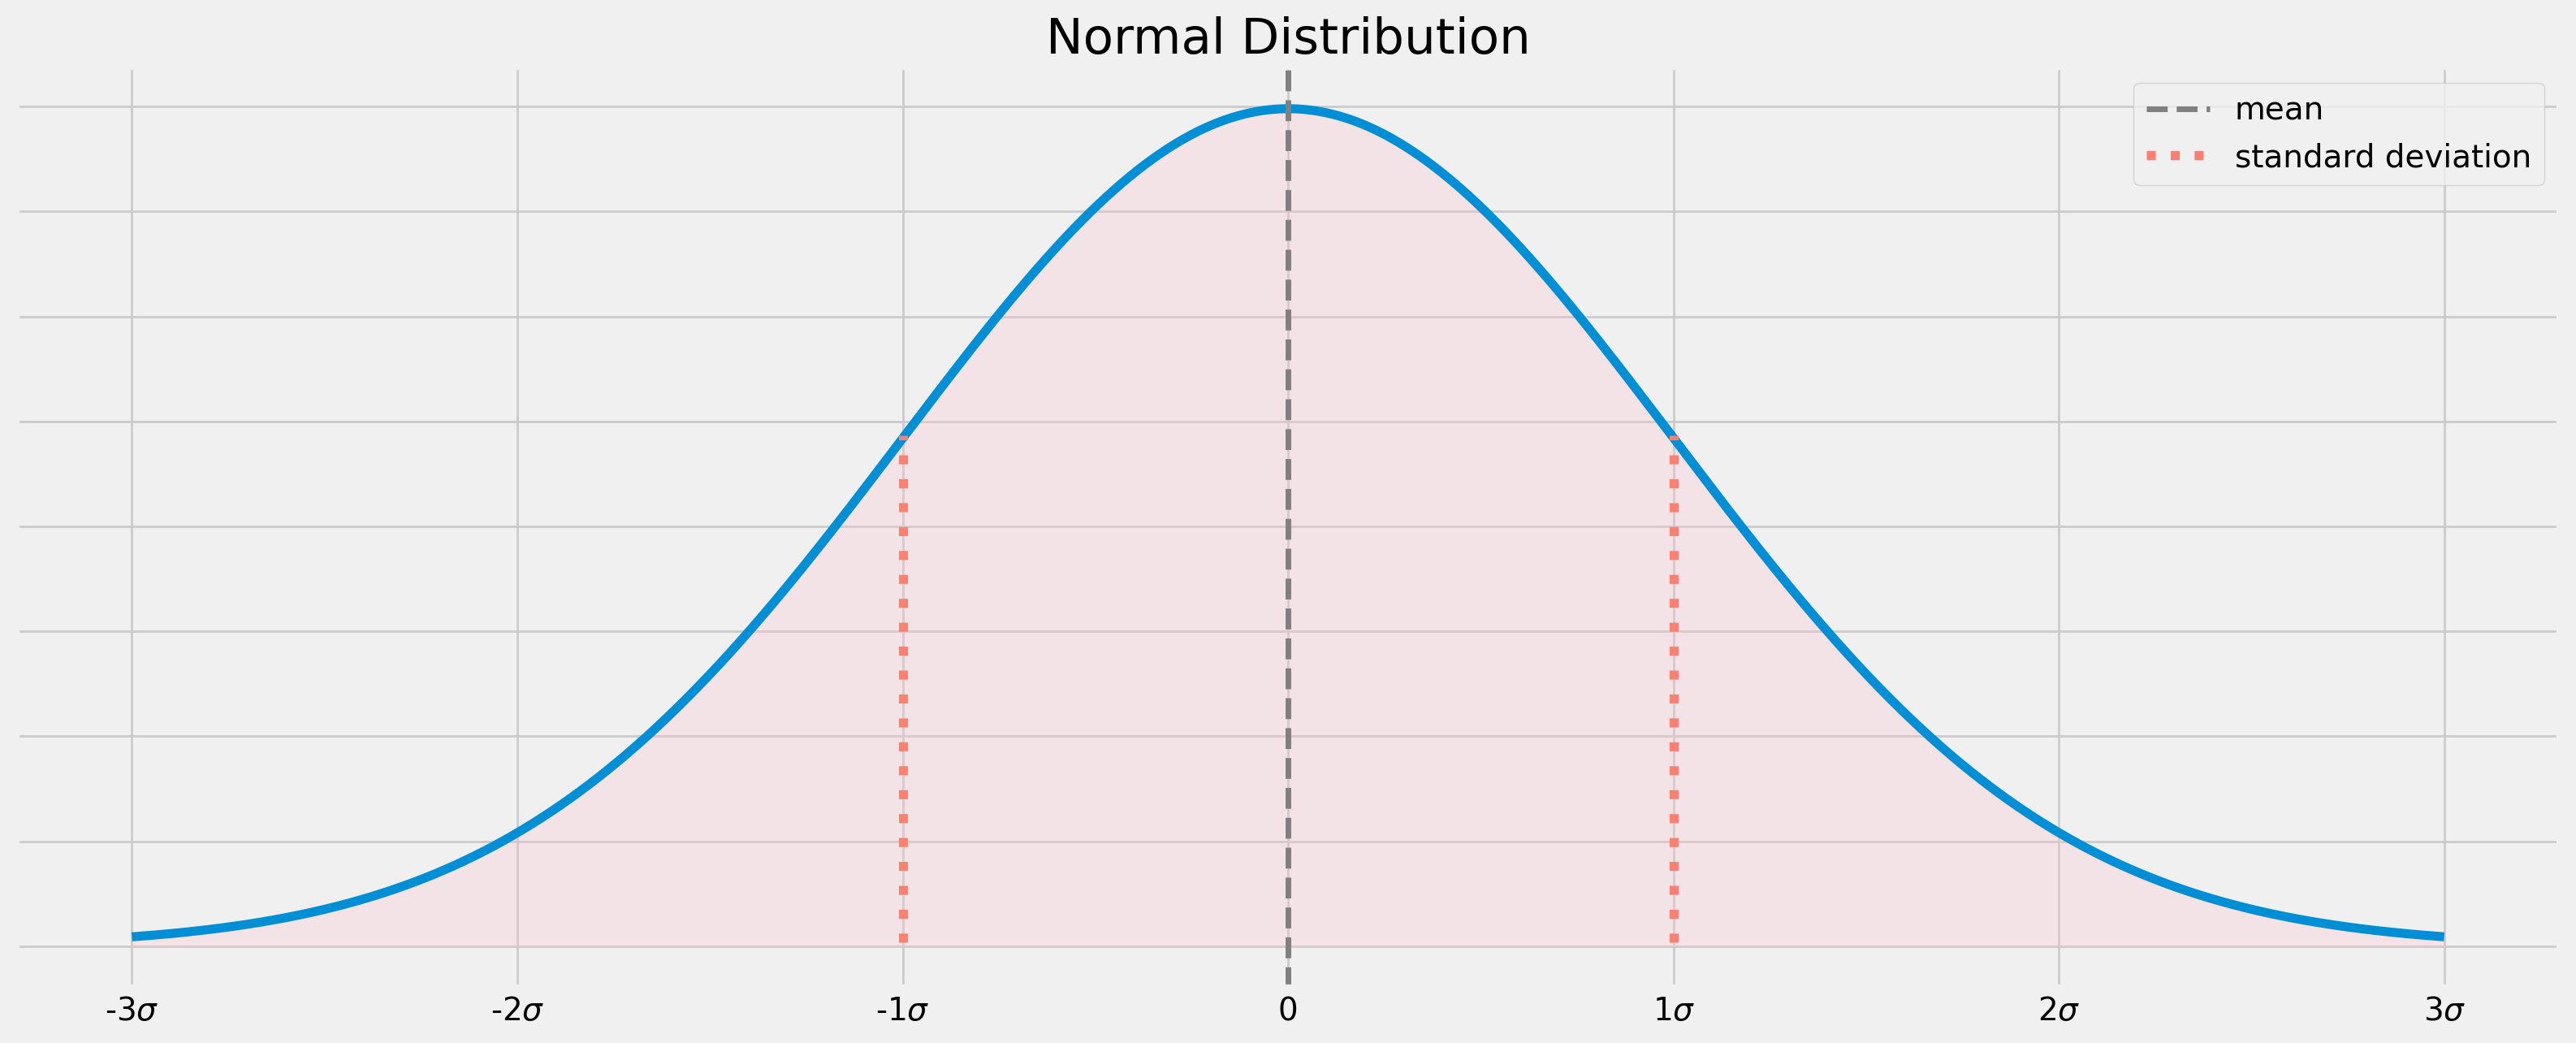

In [18]:
plt.figure(figsize=(18,7),dpi =200)
labels =["-3$\sigma$","-2$\sigma$","-1$\sigma$","0","1$\sigma$","2$\sigma$","3$\sigma$"]
tick_pos=list(np.arange(-3,4))
plt.xticks(tick_pos, labels)
plt.gca().axes.yaxis.set_ticklabels([])
# x-axis for the plot
x_axis = np.arange(-3, 3, 0.001)
# y-axis as the gaussian
y_axis = scs.norm.pdf(x_axis, 0, 1)
# plot data
plt.plot(x_axis, y_axis)
plt.fill_between(x_axis, y_axis, 0, color='pink', alpha=.25)
plt.axvline(0, ls ="--", color = "grey", label ="mean", lw =2.5)
plt.axvline(x=-1, ymin=0.05, ymax=0.6, label = "standard deviation", ls =":",color ="salmon")
plt.axvline(x=1, ymin=0.05, ymax=0.6, ls =":",color ="salmon")
plt.title("Normal Distribution", fontsize =22)
plt.legend();

## 3rd Moment ( Skewness)

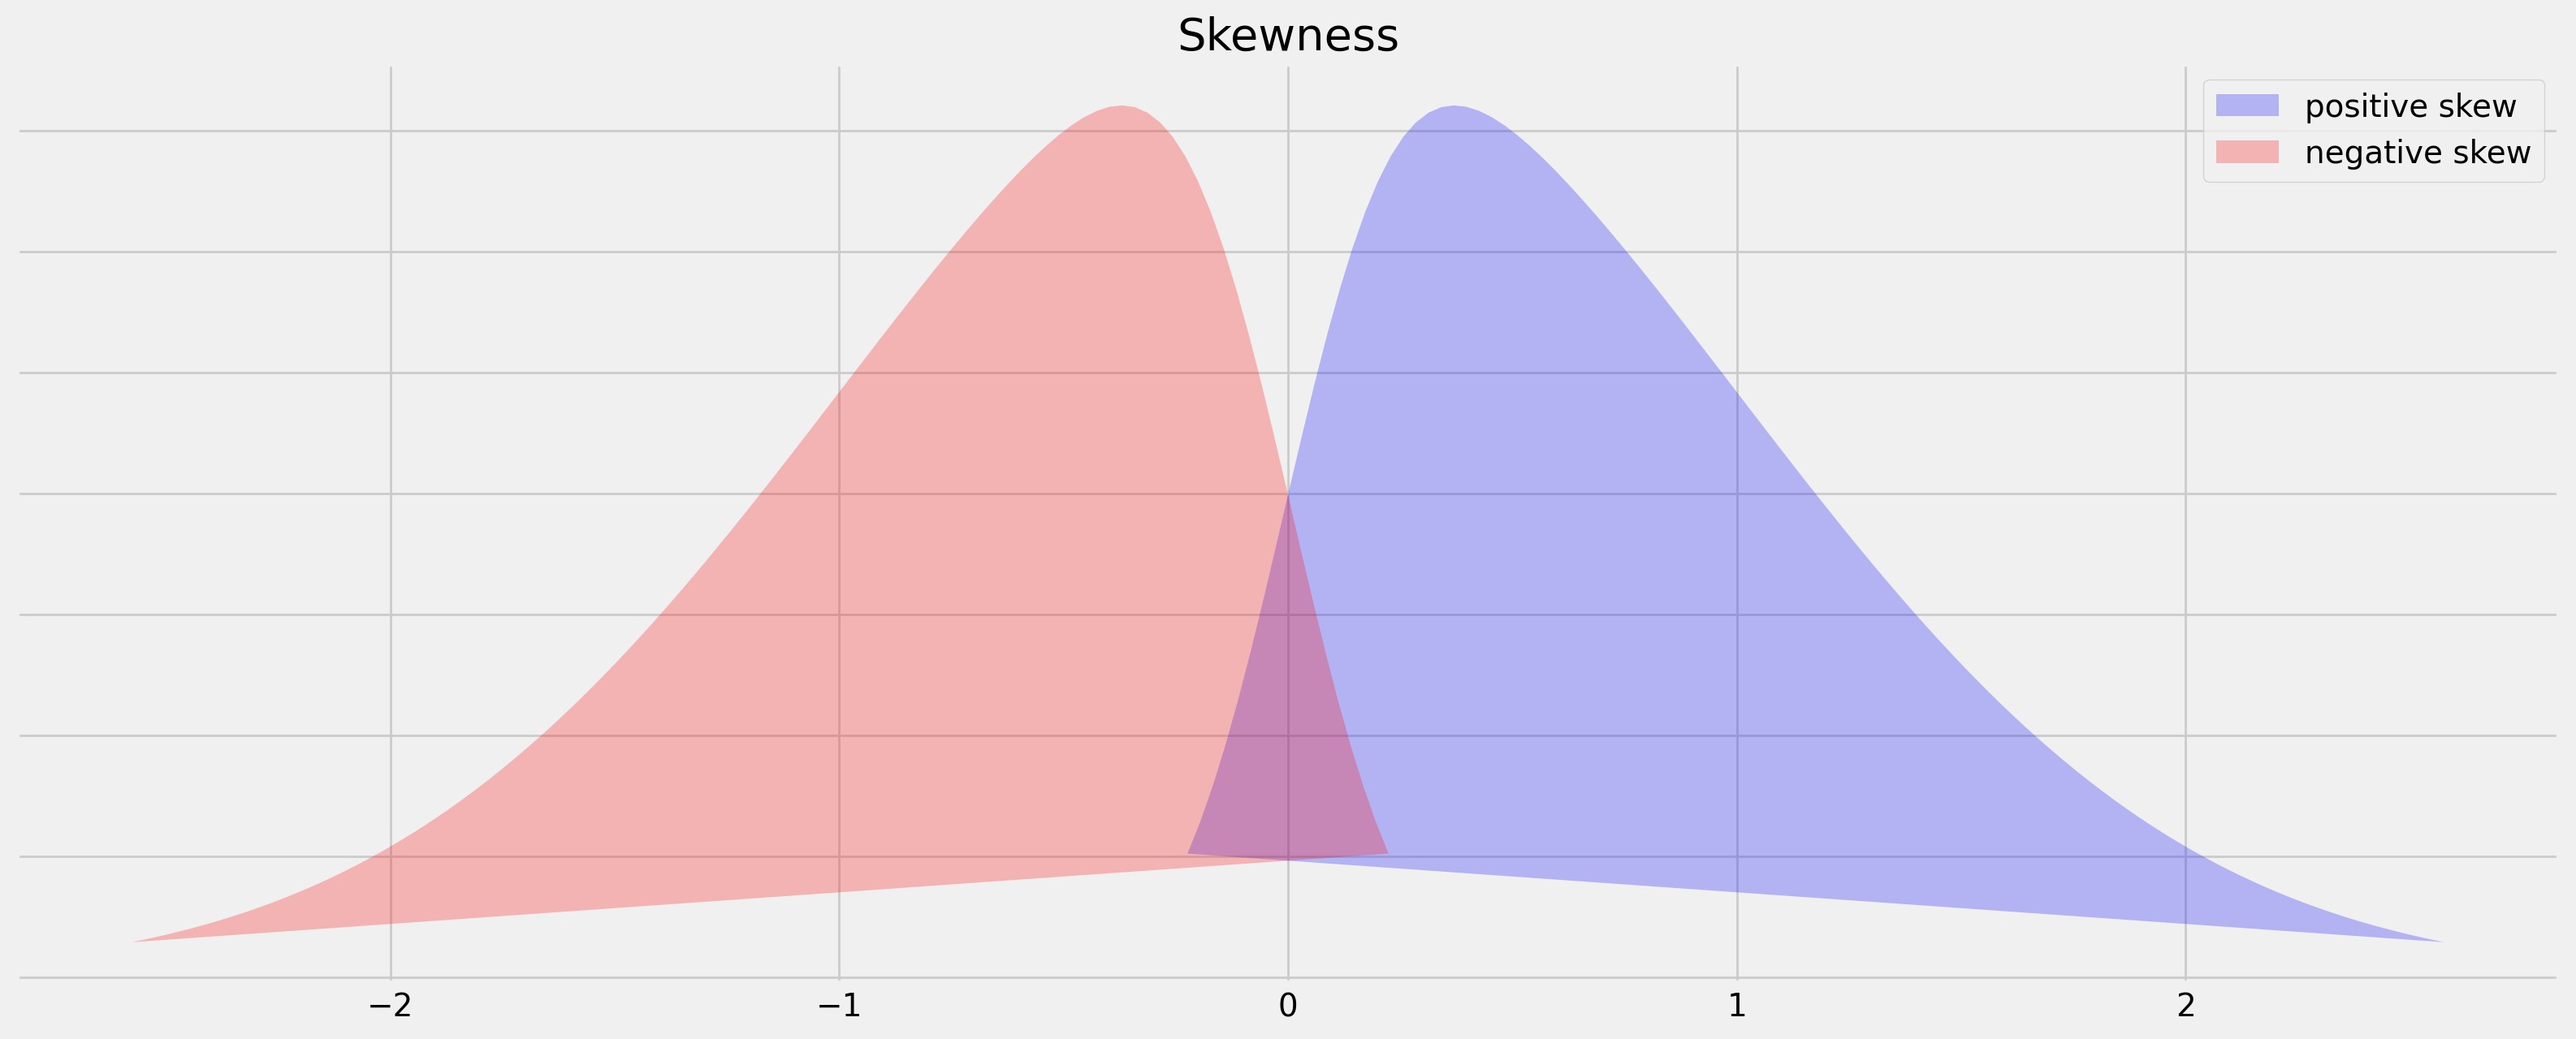

In [19]:
plt.figure(figsize=(18,7), dpi =200)
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                labelbottom=True, right='off', left='off', labelleft=False)
a =5
b=-5
x = np.linspace(scs.skewnorm.ppf(0.01, 5),scs.skewnorm.ppf(0.99, a), 100)
y = np.linspace(scs.skewnorm.ppf(0.01, -5),scs.skewnorm.ppf(0.99, b), 100)
plt.fill(x,scs.skewnorm.pdf(x, a),'b-', lw=5, alpha=0.25, label='positive skew')


plt.fill(y,scs.skewnorm.pdf(y, b),'r-', lw=5, alpha=0.25, label='negative skew' )
plt.legend()
plt.title("Skewness");

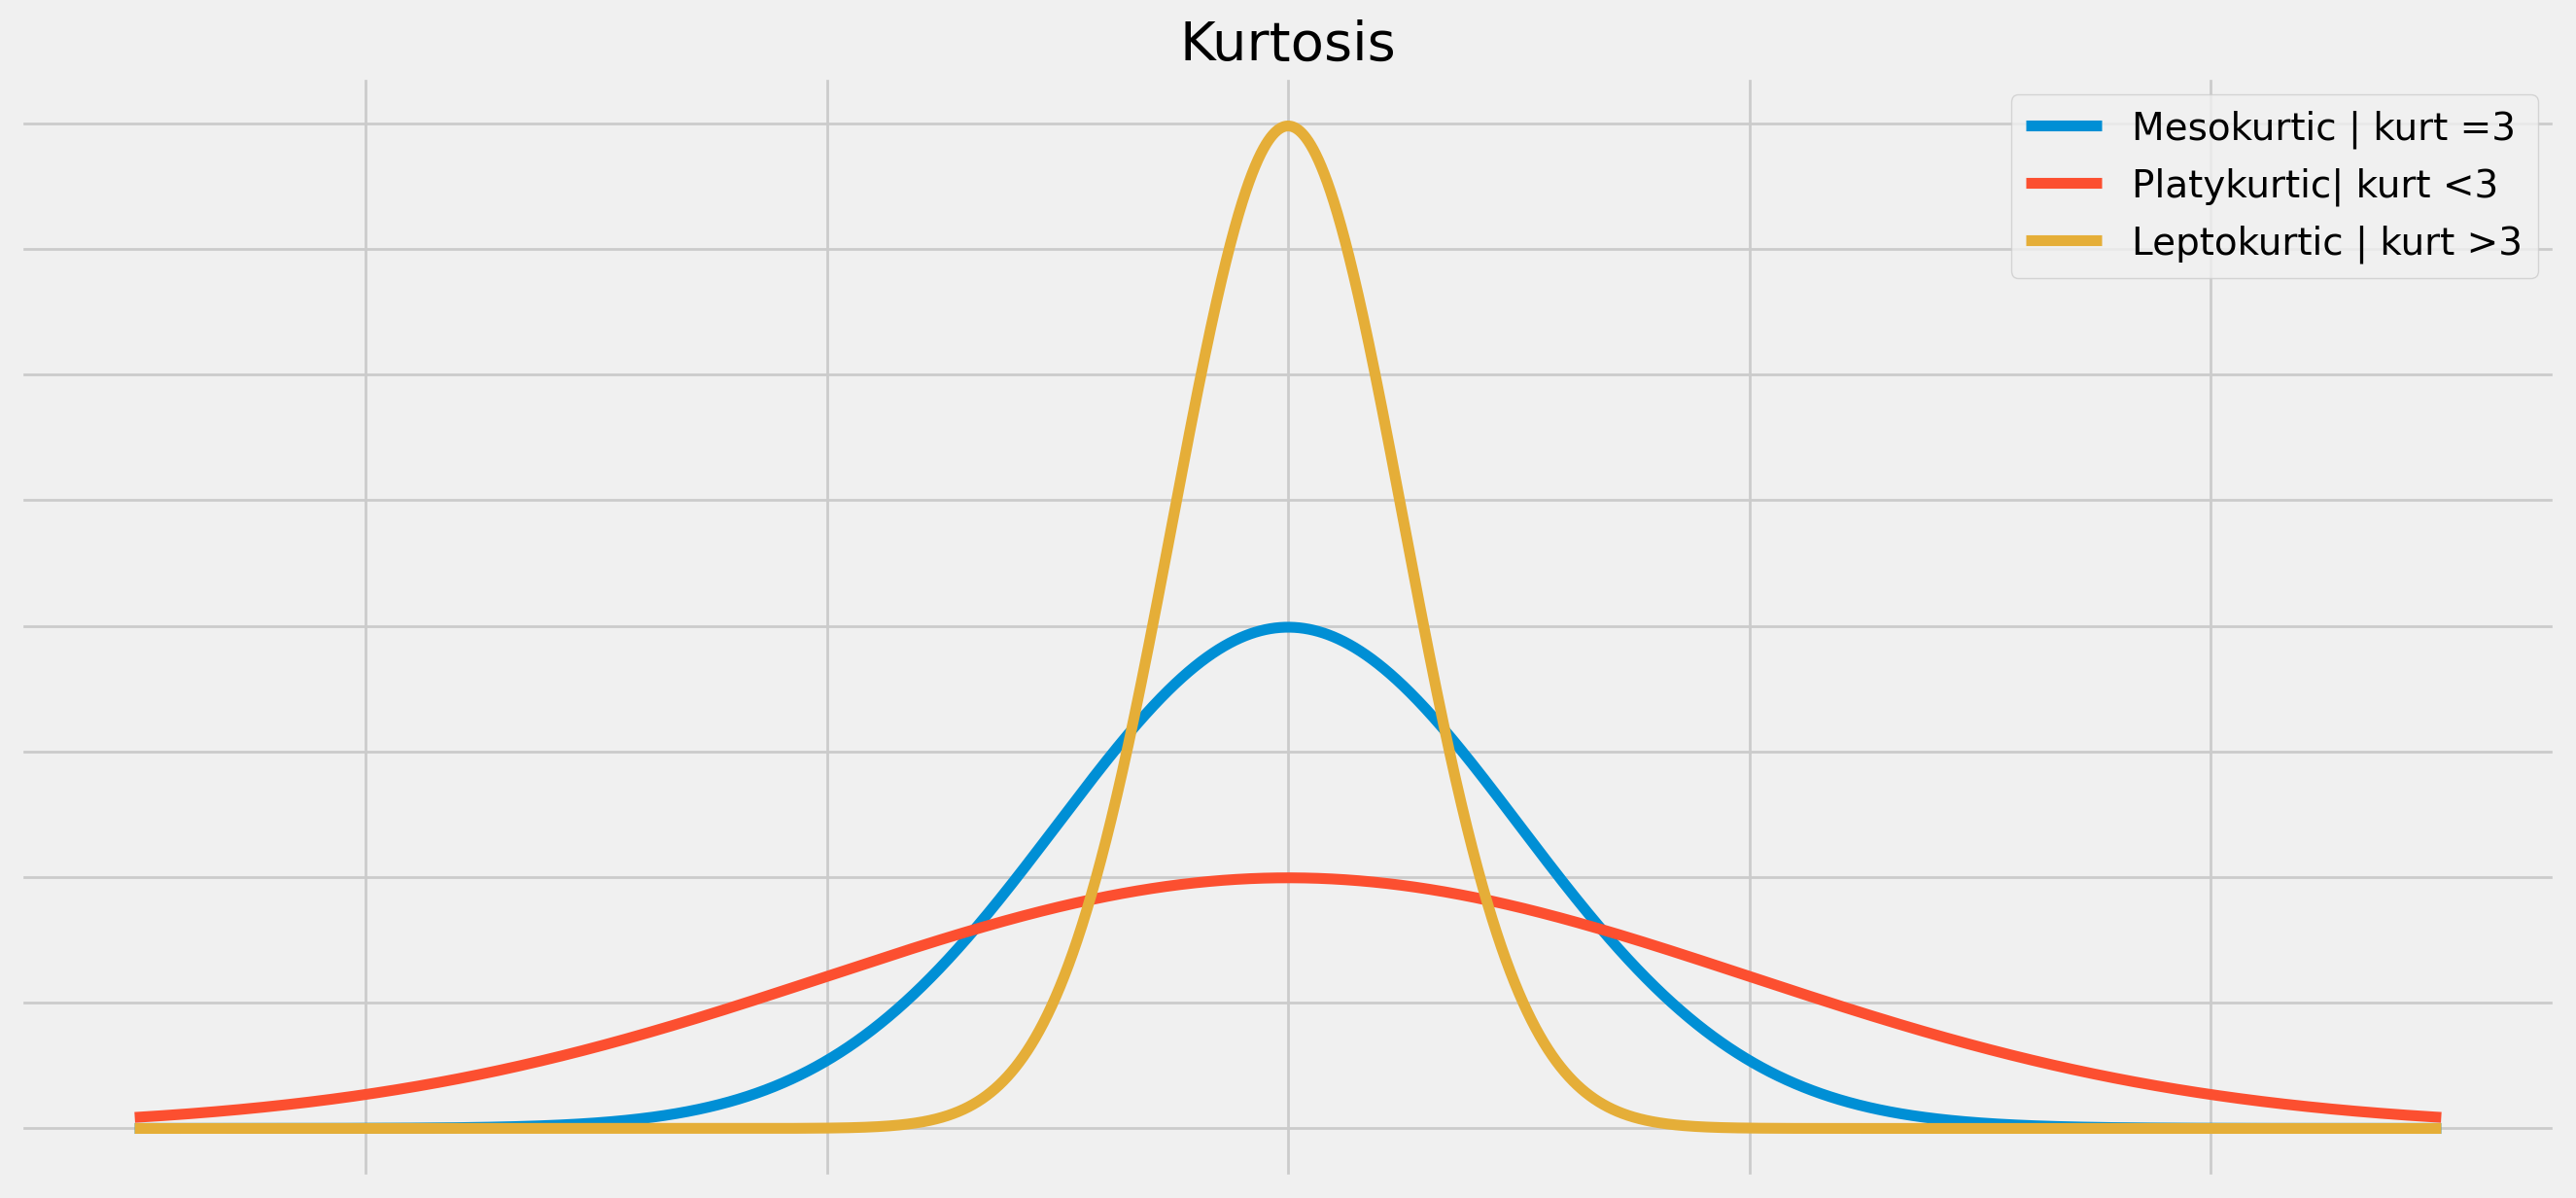

In [20]:
sample_space = np.arange(-5, 5, 0.001)
mean = 0.0
stdev = 1.0
# calculate the pdf
pdf = scs.norm.pdf(sample_space, mean, stdev)
pdf_2 = scs.norm.pdf(sample_space, mean, 2)
pdf_3 =scs.norm.pdf(sample_space, 0, 0.5)

# plot

plt.figure(figsize=(15,7), dpi =200)
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                labelbottom=False, right='off', left='off', labelleft=False)
plt.plot(sample_space, pdf, label ="Mesokurtic | kurt =3")
plt.plot(sample_space, pdf_2, label ="Platykurtic| kurt <3" )
plt.plot(sample_space, pdf_3, label ='Leptokurtic | kurt >3')
plt.legend()
plt.title("Kurtosis");

In [21]:
infy = df[["simple_rets"]].dropna()

print("Moments of Distribution of Returns (INFOSYS)\n============================================")
print(f"1st Moment-Mean of Returns     : {np.mean(infy).values[0].round(4)}")
print(f"2nd Moment-Variance of Returns : {np.var(infy).values[0].round(4)}")
print(f"3rd Moment-Skewness of Returns : {scs.skew(infy)[0].round(4)}")
print(f"4th Moment-Kurtosis of Returns : {scs.kurtosis(infy)[0].round(4) +3}")


Moments of Distribution of Returns (INFOSYS)
1st Moment-Mean of Returns     : 0.0008
2nd Moment-Variance of Returns : 0.0003
3rd Moment-Skewness of Returns : -0.2929
4th Moment-Kurtosis of Returns : 11.6081


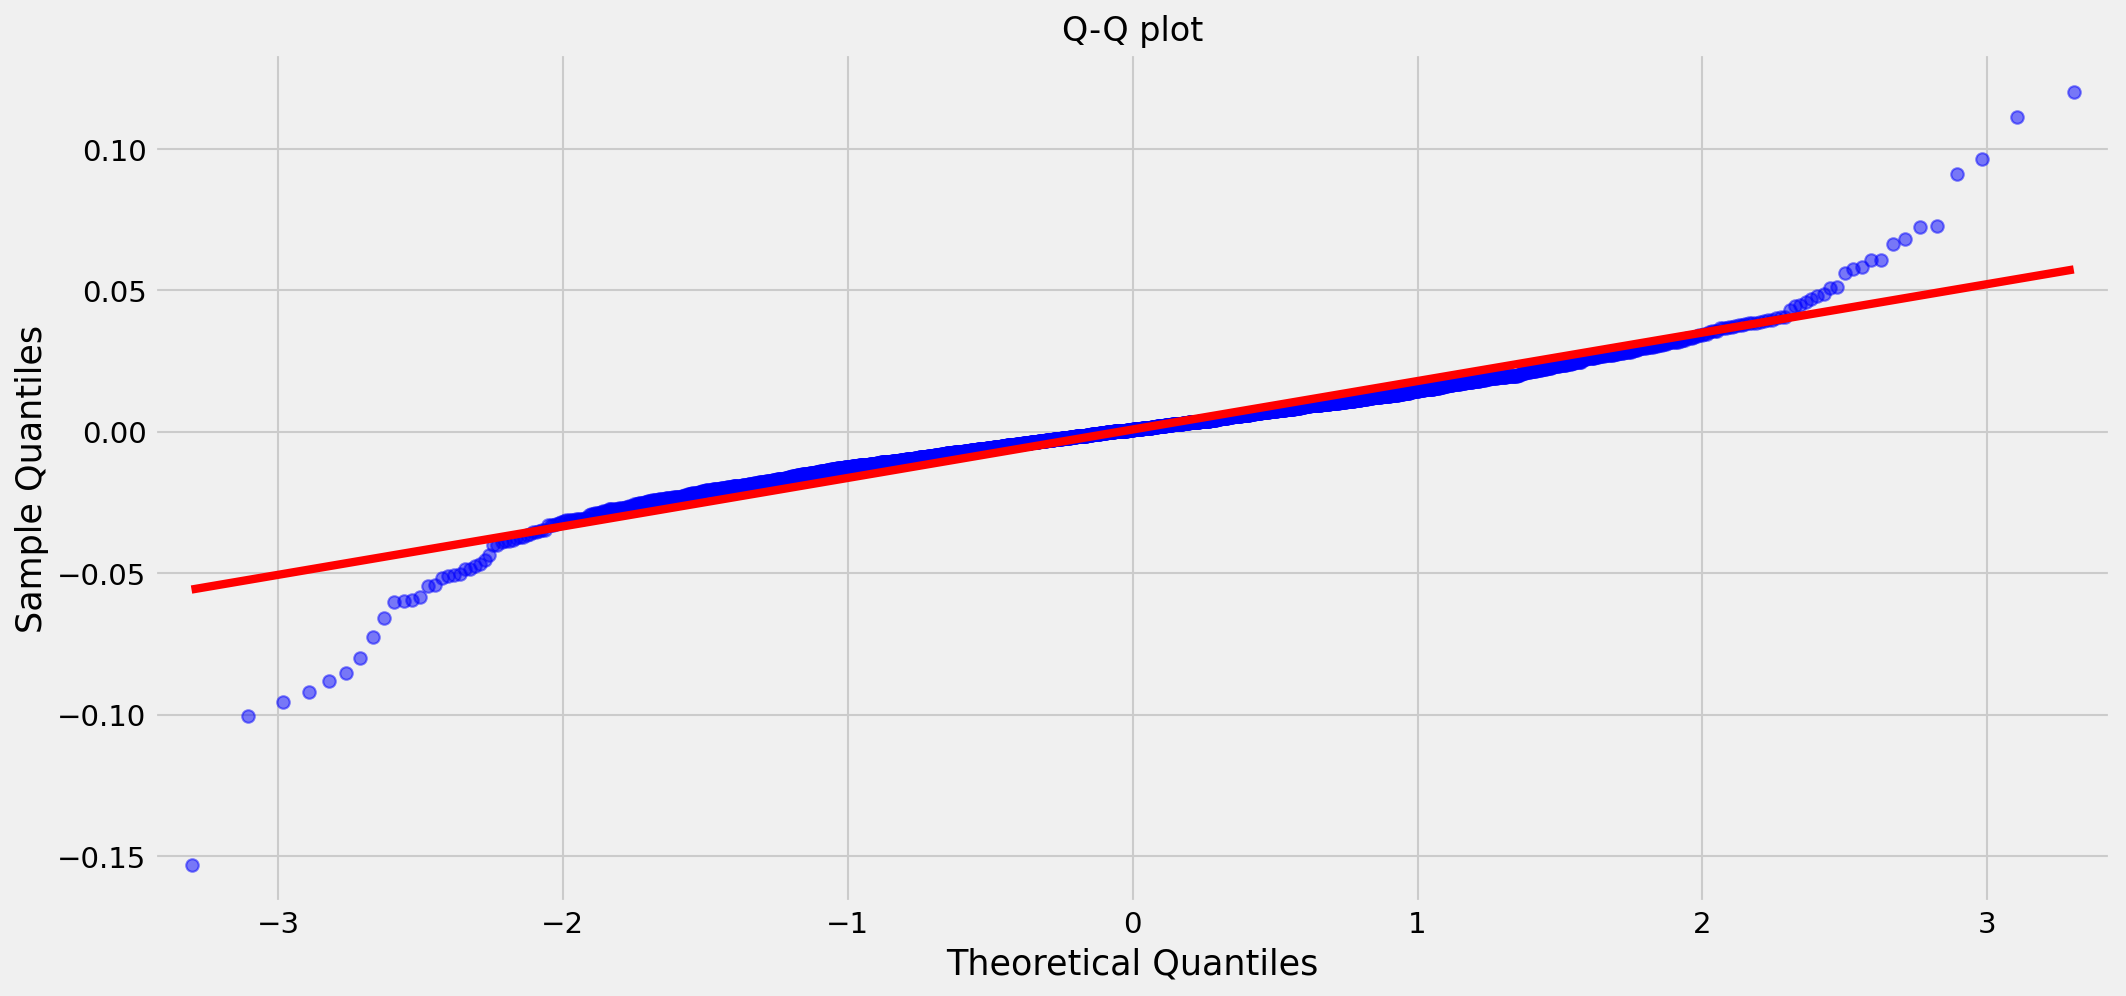

In [22]:
rets_range = np.linspace(min(df["simple_rets"].dropna()), max(df["simple_rets"].dropna()), num=100)
mu = df["simple_rets"].dropna().mean()
sigma = df["simple_rets"].dropna().std()
norm_pdf = scs.norm.pdf(rets_range, loc=mu, scale=sigma)   

fig, ax = plt.subplots(figsize=(15, 7), dpi =150)
qq = sm.qqplot(df["simple_rets"].dropna().values, line='s',  ax =ax, alpha =0.5)
plt.title('Q-Q plot', fontsize = 16);

### Tests for Normality 

#### Shapiro-Wilk normality test


In [23]:
shapiro =scs.shapiro(infy)

#### Jarque-Bera normality test

In [24]:
jaque_bera =scs.jarque_bera(infy)

In [25]:
print("Descriptive Stats \n*****************")
print(f"Date Range            : {infy.index[0].date()} to {infy.index[-1].date()}")
print(f"Number of Observations: {infy.shape[0]}")
print(f"Min.return            : {np.min(infy,axis =0).values[0].round(4)}")
print(f"Max.return            :  {np.max(infy,axis =0).values[0].round(4)}")
print(f"Mean                  :  {np.mean(infy).values[0].round(4)}")
print(f"Standard Deviation    :  {np.std(infy).values[0].round(4)}")
print(f"Skewness              : {scs.skew(infy)[0].round(4)}")
print(f"Kurtosis              : {scs.kurtosis(infy)[0].round(4) +3}")
print(f"Excess Kurtosis       :  {scs.kurtosis(infy)[0].round(4)}\n")

print(f"Shapiro-Wilk normality test :\n***************************")
print(f"Shapiro statistic: {np.round(shapiro[0],5)} with p-value: {shapiro[1]}")
print(f"p-value <= 0.05 is {scs.shapiro(infy)[1] <= 0.05}")
print(f"REJECT Null Hypothesis (H0) that returns distribution is normal at 95% confidence level\n")

print(f"Jarque-Bera normality test :\n**************************")
print(f"Jarque-Bera statistic: {jaque_bera[0].round(2)} with p-value: {jaque_bera[1]}")
print(f"p-value <= 0.01 is {jaque_bera[1] <= 0.01}")
print(f"REJECT Null Hypothesis (H0) that returns distribution is normal at 99% confidence level\n")

Descriptive Stats 
*****************
Date Range            : 2014-01-02 to 2022-06-30
Number of Observations: 2094
Min.return            : -0.1531
Max.return            :  0.1203
Mean                  :  0.0008
Standard Deviation    :  0.0171
Skewness              : -0.2929
Kurtosis              : 11.6081
Excess Kurtosis       :  8.6081

Shapiro-Wilk normality test :
***************************
Shapiro statistic: 0.92303 with p-value: 1.8752251131139516e-31
p-value <= 0.05 is True
REJECT Null Hypothesis (H0) that returns distribution is normal at 95% confidence level

Jarque-Bera normality test :
**************************
Jarque-Bera statistic: 6495.14 with p-value: 0.0
p-value <= 0.01 is True
REJECT Null Hypothesis (H0) that returns distribution is normal at 99% confidence level



In [26]:
import yfinance as yf

In [27]:
ticker = ["^DJI","^IXIC","^GSPC" ,"^NSEI","^CNXIT","^NSEBANK"]

In [28]:
df1 = yf.download(ticker, start=("2018-01-01") , end="2022-06-30", progress= False )["Adj Close"].round(2)
df1.head()

,^CNXIT,^DJI,^GSPC,^IXIC,^NSEBANK,^NSEI
Date,,,,,,
2018-01-02,11602.35,24824.01,2695.81,7006.90,25338.25,10442.20
2018-01-03,11586.70,24922.68,2713.06,7065.53,25318.60,10443.20
2018-01-04,11590.80,25075.13,2723.99,7077.91,25462.60,10504.80
2018-01-05,11633.55,25295.87,2743.15,7136.56,25601.85,10558.85
2018-01-08,11776.85,25283.00,2747.71,7157.39,25676.10,10623.60


In [29]:
df1 = df1[['^DJI', '^GSPC', '^IXIC', '^NSEI','^NSEBANK','^CNXIT']].rename(columns={'^DJI': "DowJones", 
                                                                                 '^GSPC':"SP500", 
                                                                                 '^IXIC':"Nasdaq",
                                                                                 '^NSEI': "Nifty50",
                                                                                 '^NSEBANK':"BankNifty",
                                                                                 '^CNXIT':"NiftyIT"
                                                                                                     })

In [30]:
df1.isnull().sum()

DowJones     30
SP500        30
Nasdaq       30
Nifty50      55
BankNifty    57
NiftyIT      58
dtype: int64

In [31]:
df1_rets = df1.pct_change()
df1_rets =df1_rets.iloc[1:]
df1_rets.isnull().sum()

DowJones     0
SP500        0
Nasdaq       0
Nifty50      0
BankNifty    0
NiftyIT      0
dtype: int64

In [32]:
df1_rets

,DowJones,SP500,Nasdaq,Nifty50,BankNifty,NiftyIT
Date,,,,,,
2018-01-03,0.003975,0.006399,0.008367,0.000096,-0.000776,-0.001349
2018-01-04,0.006117,0.004029,0.001752,0.005899,0.005688,0.000354
2018-01-05,0.008803,0.007034,0.008286,0.005145,0.005469,0.003688
2018-01-08,-0.000509,0.001662,0.002919,0.006132,0.002900,0.012318
2018-01-09,0.004066,0.001303,0.000865,0.001261,0.001079,0.001189
...,...,...,...,...,...,...
2022-06-23,0.006372,0.009532,0.016205,0.009300,0.008820,0.019623
2022-06-24,0.026838,0.030563,0.033424,0.009166,0.014862,-0.008920
2022-06-27,-0.001982,-0.002973,-0.007157,0.008459,0.005466,0.020453


In [33]:
[df1_rets[col].mean() for col in df1_rets.columns]

[0.00028697475449944844,
 0.0003920162229803432,
 0.0005264790017951268,
 0.0004339603126084595,
 0.0003777533041356282,
 0.0008695512026638414]

In [34]:
skew =scs.skew(df1_rets)

In [35]:
all = pd.DataFrame(zip(df1_rets.columns,skew))
all.columns = ["Asset/Index", "Skewness"]
all["Kurtosis"] = scs.kurtosis(df1_rets)+3
all["Mean"] = [df1_rets[col].mean() for col in df1_rets.columns]
all["Median"] = [df1_rets[col].median() for col in df1_rets.columns]
all["Std. Deviation"]= [df1_rets[col].std() for col in df1_rets.columns]
all["Shapiro p-value (< 0.05)"] =[scs.shapiro(df1_rets)[1]<=0.05 for col in df1_rets.columns]
all["Jarque Bera p-value (< 0.01)"] =[scs.jarque_bera(df1_rets)[1]<=0.05 for col in df1_rets.columns]
all

C:\Users\prita\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Asset/Index,Skewness,Kurtosis,Mean,Median,Std. Deviation,Shapiro p-value (< 0.05),Jarque Bera p-value (< 0.01)
0,DowJones,-0.592851,21.230217,0.000287,0.000482,0.013713,True,True
1,SP500,-0.625944,16.930644,0.000392,0.000763,0.013507,True,True
2,Nasdaq,-0.576640,10.349560,0.000526,0.001002,0.015688,True,True
3,Nifty50,-1.197302,20.893232,0.000434,0.000212,0.012340,True,True
4,BankNifty,-0.793313,16.659102,0.000378,0.000000,0.016824,True,True
5,NiftyIT,-0.406378,9.579565,0.000870,0.000467,0.014501,True,True


In [36]:
all = all[['Asset/Index','Mean','Median','Std. Deviation', 'Skewness', 'Kurtosis', 'Shapiro p-value (< 0.05)',
              'Jarque Bera p-value (< 0.01)']]
all.set_index("Asset/Index")

,Mean,Median,Std. Deviation,Skewness,Kurtosis,Shapiro p-value (< 0.05),Jarque Bera p-value (< 0.01)
Asset/Index,,,,,,,
DowJones,0.000287,0.000482,0.013713,-0.592851,21.230217,True,True
SP500,0.000392,0.000763,0.013507,-0.625944,16.930644,True,True
Nasdaq,0.000526,0.001002,0.015688,-0.576640,10.349560,True,True
Nifty50,0.000434,0.000212,0.012340,-1.197302,20.893232,True,True
BankNifty,0.000378,0.000000,0.016824,-0.793313,16.659102,True,True
NiftyIT,0.000870,0.000467,0.014501,-0.406378,9.579565,True,True
